#  HEP-Th Runtime experiments

In this notebook we measure the runtime of forward, backward, and inference computations for graph edit networks (without edge filtering, with edge filtering, and with a constant number of maximum edge-edited nodes) on realistic graphs from the HEP-Th dataset.

In [1]:
from tqdm import tqdm

In [9]:
import time
import numpy as np
import torch
import pytorch_graph_edit_networks as gen
import hep_th

# model parameters
num_layers = 3
dim_hid = 64
nonlin = torch.nn.Tanh()

# initialize model, one without edge filters, one with edge filters, but no limit, and one
# with limit
filter_options = [True, 538]
# set up model names for result storage
model_names = ['flex_filter', 'const_filter']
comp_names  = ['forward', 'backward']
headers = ['sizes']
for model_name in model_names:
    for comp_name in comp_names:
        headers.append('%s_%s' % (model_name, comp_name))

max_past = 12


# set up a list of all experimental settings
month_tuples = []
for year in range(1992,2003+1):
    max_month = 12
    if year == 2003:
        max_month = 4
    for month in range(1, max_month+1):
        month_tuples.append((year, month))
settings = []
for past in range(1, max_past+1):
    for t in range(past, len(month_tuples)):
        settings.append((month_tuples[t][0], month_tuples[t][1], past))


In [97]:
learning_rate  = 1E-3
weight_decay   = 1E-5

fee = 538

xx = 0
curves = {}
learning_curve = []

month_tuples = []
for year in range(1992,2003+1):
    max_month = 12
    if year == 2003:
        max_month = 4
    for month in range(1, max_month+1):
        month_tuples.append((year, month))
settings = []
for past in range(1, max_past+1):
    for t in range(past, len(month_tuples)):
        settings.append((month_tuples[t][0], month_tuples[t][1], past))

net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = fee)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
learning_curve2 = []
for epoch in range(1):
    print(f'epoch: {epoch}')
    for iter, sets in tqdm(enumerate(settings)):
        optimizer.zero_grad()
        year, month, past = settings[iter]
        loss = hep_th.compute_loss(net, year, month, past = past)
        loss.backward()
        optimizer.step()
        learning_curve2.append(loss.item())
        (epoch*len(sets) + iter)
        if (epoch*len(sets) + iter)%100 == 0: print(loss.item())



epoch: 0
5035.21044921875
50525.1328125
18050.181640625
28801.29296875
140276.625
218268.0
174037.796875
130886.90625
73550.4140625
585158.375
310353.71875
359091.25
207717.859375
1020347.9375
778929.9375
599114.0625


[0, 135, 269, 402, 534, 665, 795, 924, 1052, 1179, 1305, 1430]


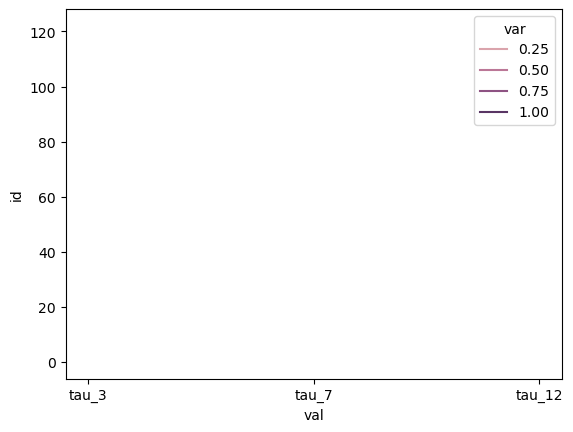

In [157]:
breakpoints = []
tau = 0
for ind, i in enumerate(settings):
    temp_tau = i[2]
    if temp_tau != tau:
        tau = temp_tau
        breakpoints.append(ind)

print(breakpoints)
import seaborn as sns
from matplotlib import pyplot as plt
#sns.lineplot(x=range(len(learning_curve2)), y=learning_curve2)

tau_3 = learning_curve2[breakpoints[2]:breakpoints[3]]
tau_7 = learning_curve2[breakpoints[6]:breakpoints[7]]
tau_12 = learning_curve2[breakpoints[11]:]


taus = {'tau_3' : tau_3, 'tau_7' : tau_7, 'tau_12' : tau_12}
import pandas as pd
#melted = df.melt(df.reset_index(), id_vars=['index'])

#

#
#plt.show()
#melted
#
#


In [161]:
df = pd.DataFrame.from_dict(taus, orient='index').T
df = df.iloc[:123, :]
df

,tau_3,tau_7,tau_12
0,7026.757324,42528.703125,1.241476e+05
1,9708.089844,69611.687500,1.447055e+05
2,12582.860352,74809.625000,1.526141e+05
3,16106.833008,67489.054688,1.864247e+05
4,12625.918945,87506.710938,1.690862e+05
...,...,...,...
118,111445.023438,474214.718750,1.083358e+06
119,94560.617188,487707.250000,1.207305e+06
120,87708.195312,397163.531250,9.382825e+05
121,114533.125000,457889.500000,8.489419e+05


In [172]:
melted = pd.melt(df.reset_index(), id_vars=['index'])
melted.columns = ['iteration', r'$\tau$', 'loss']
melted

,iteration,$\tau$,loss
0,0,tau_3,7.026757e+03
1,1,tau_3,9.708090e+03
2,2,tau_3,1.258286e+04
3,3,tau_3,1.610683e+04
4,4,tau_3,1.262592e+04
...,...,...,...
364,118,tau_12,1.083358e+06
365,119,tau_12,1.207305e+06
366,120,tau_12,9.382825e+05
367,121,tau_12,8.489419e+05


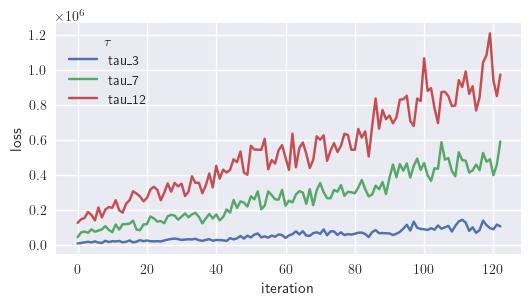

In [178]:
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['text.usetex'] = True
#sns.lineplot(data=melted, x='id', y='val', hue='var')
#plt.show()
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(data=melted, x='iteration', y='loss', hue=r'$\tau$', ax=ax)
plt.savefig('LossCurves.png', bbox_inches='tight')
plt.show()

In [23]:
# check which models still need to be processed
import os

for repetition in range(6,7):
#     print(f'****** new rep!!! {repetition}/4')
# # try to load prior runtime results from disk
#
#     if os.path.exists(f'hep_th_runtimes_{repetition}.csv'):
#         data     = np.loadtxt(f'hep_th_runtimes_{repetition}.csv', delimiter='\t', skiprows = 1)
#         sizes    = data[:, 0]
#         Runtimes = data[:, 1:].T
#     else:
#         Runtimes = np.zeros((len(filter_options) * 2, len(settings)))
#         # compute graph sizes
#         sizes = np.zeros(len(settings))
#         s = 0
#         for past in range(1, max_past+1):
#             for t in range(past, len(month_tuples)):
#                 past_months = month_tuples[(t-past):t]
#                 A, I = hep_th.read_graph_from_csv('hep-th/graphs/%d_%d.csv' % (past_months[0][0], past_months[0][1]))
#                 for past_month in past_months[1:]:
#                     # parse the current graph from CSV data
#                     B, J = hep_th.read_graph_from_csv('hep-th/graphs/%d_%d.csv' % (past_month[0], past_month[1]))
#                     # add B, J to A, I
#                     A, I = hep_th.add_graph(A, I, B, J)
#                 sizes[s] = len(I)
#                 s += 1
#
#     remaining_models = []
#     for model_idx in range(len(filter_options)):
#         if np.any(Runtimes[model_idx*2:(model_idx+1)*2, :] < 1E-8):
#             remaining_models.append(model_idx)
#     # iterate over all models
#     for model_idx in remaining_models:
#         print('processing edge filter option %s' % str(filter_options[model_idx]))
#         # check all remaining experimental settings
#         remaining_settings = np.where(np.any(Runtimes[model_idx*2:(model_idx+1)*2, :] < 1E-8, 0))[0]
#         # iterate over all possible experimental settings
#         last_past = -1



    for s in remaining_settings:
            net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = filter_options[model_idx])
            year, month, past = settings[s]
            if past != last_past:
                if last_past > 0:
                    print('required a total time of %g seconds' % np.sum(Runtimes[(model_idx*2):(model_idx*2+2), last_s:s]))
                print('considering %d past months for graph construction' % past)
                curves[last_past] = learning_curve
                last_past = past
                last_s = s
                learning_curve = []
            # initialize a new network
            for epoch in range(400):
                loss = hep_th.compute_loss(net, year, month, past = past)
                loss.backward()
                optimizer.step()
                epoch += 1
                learning_curve.append(loss.item())
                if xx%100 == 0: print(loss.item())

****** new rep!!! 6/4
processing edge filter option True
considering 1 past months for graph construction
337720.6875
required a total time of 14.7213 seconds
considering 2 past months for graph construction
1014588.0
required a total time of 14.9844 seconds
considering 3 past months for graph construction
2195112.75
7822149.5
required a total time of 27.0886 seconds
considering 4 past months for graph construction
4298928.0
required a total time of 38.8984 seconds
considering 5 past months for graph construction
29856168.0
required a total time of 49.6903 seconds
considering 6 past months for graph construction
68614384.0
required a total time of 60.1152 seconds
considering 7 past months for graph construction
16837490.0
146197088.0
required a total time of 69.2344 seconds
considering 8 past months for graph construction
148055536.0
required a total time of 78.4097 seconds
considering 9 past months for graph construction
63527276.0
required a total time of 87.5554 seconds
considering 

In [77]:
import pandas as pd
curves2 = curves.copy()
curves2.pop(-1, None)
df = pd.DataFrame.from_dict(curves2, orient='index').T.reset_index()
df = df.iloc[:124, :]
melted = pd.melt(df, id_vars=['index'])
melted.columns = ['id', 'var', 'val']
melted

,id,var,val
0,0,1,16003.307617
1,1,1,3542.890625
2,2,1,11734.423828
3,3,1,8355.238281
4,4,1,13891.983398
...,...,...,...
1359,119,11,538316864.0
1360,120,11,539208960.0
1361,121,11,567608704.0
1362,122,11,593236352.0


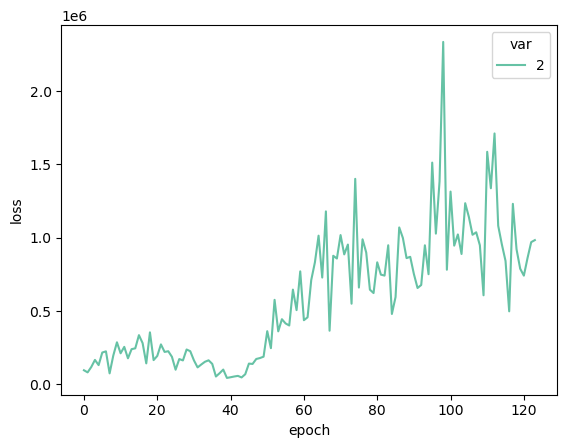

In [86]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
sns.color_palette("Set2")
m2 = melted.loc[melted['var'] == 2]
sns.lineplot(data=m2, x='id', y='val', hue='var', palette='Set2')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

log-fit for forward computation of flexible filtering model: log(y) = 1.40485 * log(x) + -10.942
log-fit for forward computation of constant filtering model: log(y) = 1.29988 * log(x) + -10.0632
log-fit for backward computation of flexible filtering model: log(y) = 1.29464 * log(x) + -13.8543
log-fit for backward computation of constant filtering model: log(y) = 1.57784 * log(x) + -14.0527


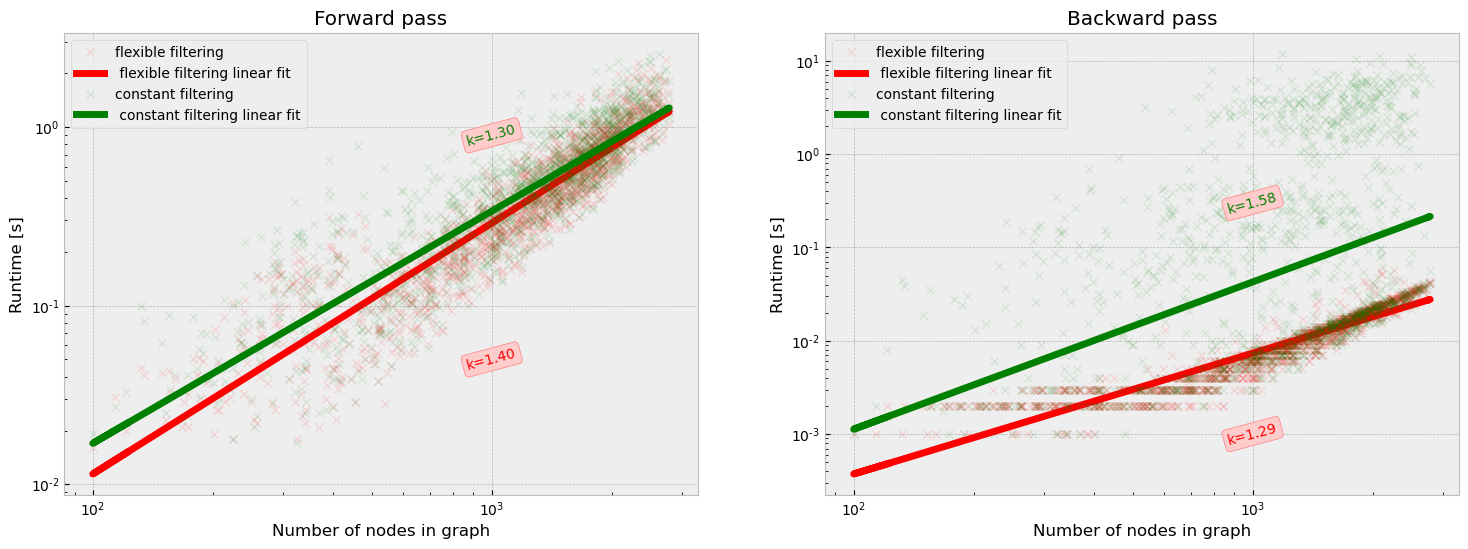

In [37]:
# load results again
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
plt.style.use('bmh')
data     = np.loadtxt('hep_th_runtimes_1.csv', delimiter='\t', skiprows = 1)
sizes    = data[:, 0]
Runtimes = data[:, 1:-2].T

model_names = ['flexible filtering', 'constant filtering']
colors = 'rgb'
comp_names  = ['forward', 'backward']
titles = ['Forward pass', 'Backward pass']
pos = [(0.05, 0.9,), (0.001, 0.3,)]
cs = ('red', 'green', 'blue')
rot = [[15., 15., 65.], [15., 15., 35.]]
fig, axx = plt.subplots(1,2, figsize=(18,6))
for c in range(len(comp_names)):
    ax = axx[c]
    for model_idx in range(len(model_names)):
        # perform a log-log linear fit
        y = Runtimes[model_idx * 2 + c, :]
        x = sizes[y > 1E-8]
        y = y[y > 1E-8]
        w, b, _, _, _ = linregress(np.log(x), np.log(y))
        print('log-fit for %s computation of %s model: log(y) = %g * log(x) + %g' % (comp_names[c], model_names[model_idx], w, b))
        # plot the data and the log fit
        ax.loglog(x, y, colors[model_idx] + 'x', alpha=0.1)
        ax.loglog(x, np.power(x, w) * np.exp(b), colors[model_idx] + '-', linewidth=5)
        ax.set_title(titles[c])
        ax.text(1000, pos[c][model_idx], f"k={w:.2f}", size=10, rotation=rot[c][model_idx], color=cs[model_idx],
                 ha="center", va="center",
                 bbox=dict(boxstyle="round",
                           ec=(1., 0.5, 0.5),
                           fc=(1., 0.8, 0.8),
                           facecolor='wheat',
                           )
                 )

legend_strings = []
for model_idx in range(len(model_names)):
    legend_strings.append(model_names[model_idx])
    legend_strings.append(f' {model_names[model_idx]} linear fit')

axx[1].set_xlabel('Number of nodes in graph')
axx[0].set_xlabel('Number of nodes in graph')
axx[0].set_ylabel('Runtime [s]')
axx[1].set_ylabel('Runtime [s]')
axx[0].legend(legend_strings)
axx[1].legend(legend_strings)
fig = plt.gcf()
plt.rcParams['savefig.facecolor']='white'
#fig.set_size_inches(13, 10)
plt.savefig('results/arXiv3.png')
plt.show()

In [11]:
datadata     = np.loadtxt('hep_th_runtimes_4.csv', delimiter='\t', skiprows = 1)
datadata

array([[1.21000e+02, 2.99976e-02, 1.00017e-03, ..., 1.60050e-02,
        0.00000e+00, 0.00000e+00],
       [1.14000e+02, 2.79977e-02, 2.00081e-03, ..., 1.00040e-03,
        0.00000e+00, 0.00000e+00],
       [1.32000e+02, 4.19962e-02, 1.00064e-03, ..., 2.00105e-03,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.78100e+03, 9.09000e-01, 3.80030e-02, ..., 5.20008e-02,
        0.00000e+00, 0.00000e+00],
       [2.76800e+03, 1.34600e+00, 4.20043e-02, ..., 1.69100e+00,
        0.00000e+00, 0.00000e+00],
       [2.78300e+03, 1.41400e+00, 3.89998e-02, ..., 6.80008e-02,
        0.00000e+00, 0.00000e+00]])

In [29]:
import pandas as pd
for i in range(5):
    d = np.loadtxt(f'hep_th_runtimes_{i+1}.csv', delimiter='\t', skiprows = 1)
    df = pd.DataFrame(d)
    df = df[range(5)]
    df.columns = ['Graph size', 'Flexible forward', 'Constant forward', 'Flexible backward', 'Constant backward']
    df.to_csv(f'hep_th_runtimes_conv_{i+1}.csv', index=False)